# Определение возраста по фото

В этом проекте мы обучим модель, которая будет определять возраст человека по его фотографии.

## Импорт библиотек

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

## Загрузка данных

In [3]:
target = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
target.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## Исследовательский анализ данных

Статистический анализ показателя real_age
--------------------------------------------------------------------------------------------------------------


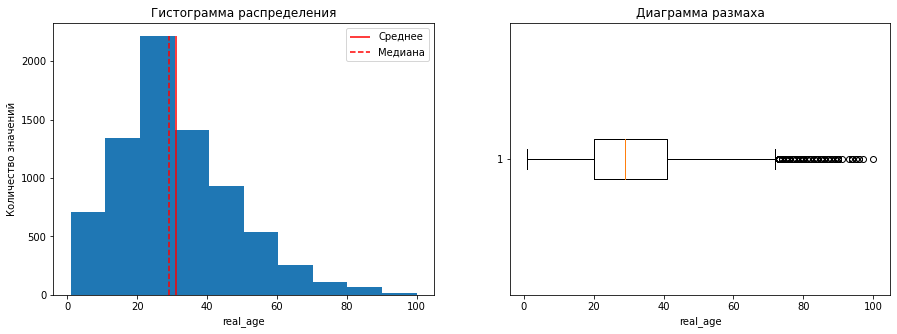

In [6]:
stat_plots(target.drop('file_name', axis=1))

In [7]:
target.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

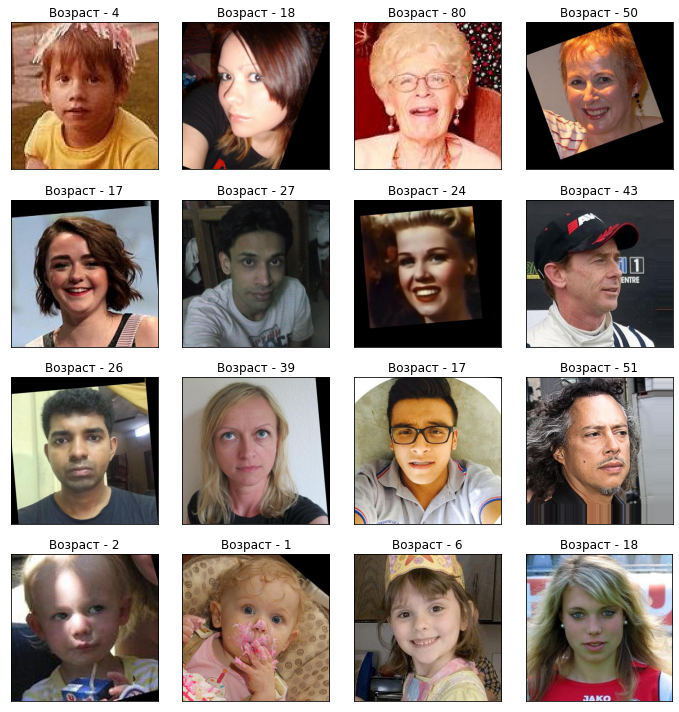

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    image = Image.open('/datasets/faces/final_files/' + target.file_name[i])
    fig.add_subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(f'Возраст - {target.real_age[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В нашем распоряжении выборка из 7591 фотографии людей и данные об их возрасте.\
Возраст людей на фотографиях распределен нормально со смещением влево.\
Средний возраст составляет 31 год.\
Выборочный просмотр изображений показывает, что данне о возрасте корректные.\
Для обучения модели мало данных людей возрастом выше 80 лет. В связи с этим, модель возможно будет больше ошибаться на фотографиях людей старше 80 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

# path = '/datasets/faces/'


def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.25)
    train_data = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        target_size=(150, 150),
        subset="training",
        seed=12345
    )
    return train_data

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        target_size=(150, 150),
        subset="validation",
        seed=12345
    )
    return test_data


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss="mean_squared_error", metrics=['mae'])
    return model

def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=20,
    steps_per_epoch=None,
    validation_steps=None,
):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-07-09 15:18:56.747600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-09 15:18:58.332505: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 78s - loss: 243.2903 - mae: 11.8437 - val_loss: 369.2395 - val_mae: 14.3241
Epoch 2/10
178/178 - 36s - loss: 145.3744 - mae: 9.2408 - val_loss: 334.7762 - val_mae: 13.5657
Epoch 3/10
178/178 - 38s - loss: 111.9363 - mae: 8.0516 - val_loss: 457.6880 - val_mae: 16.2667
Epoch 4/10
178/178 - 38s - loss: 80.2811 - mae: 6.8982 - val_loss: 257.5461 - val_mae: 11.7742
Epoch 5/10
178/178 - 37s - loss: 59.0614 - mae: 5.9682 - val_loss: 138.2364 - val_mae: 8.8569
Epoch 6/10
178/178 - 38s - loss: 39.5670 - mae: 4.8618 - val_loss: 175.1630 - val_mae: 10.6225
Epoch 7/10
178/178 - 37s - loss: 30.7506 - mae: 4.3109 - val_loss: 130.5834 - val_mae: 8.5712
Epoch 8/10
178/178 - 37s - loss: 21.2427 - mae: 3.5724 - val_loss: 101.8303 - val_mae: 7.5781
Epoch 9/10
178/178 - 37s - loss: 16.7841 - mae: 3.1475 - val_loss: 100.7771 - val_mae: 7.5670
Epoch 10/10
178/178 - 38s - loss: 12.2834 - mae: 2.7082 - val_loss: 112.4432 - val_mae: 7.8815

```

## Анализ обученной модели

В процессе выполнения проекта мы обучали модель ResNet50 на 10 и 20 эпохах.\
Наилучший результат на валидации был получен на 15 эпохе при обучении на 20 эпохах и составил величину MAE = 7.003\
Однако, дальнейшее обучение увеличило размер ошибки выше 8.\
Итоговое обучение для целей настоящего проекта было произведено на 10 эпохах, результаты которых приведены в предыдущем разделе.